Import necessary libraries

In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras

Define file paths for training, development, and test data

In [2]:
train_path = 'train/'
dev_path = 'dev/'
test_path = 'test/'

Function to one-hot encode labels, load data from CSV and label data

In [3]:
# Function to one-hot encode labels
def one_hot_label(csv_file):
    label = csv_file.split('_')[0]
    return np.array([1, 0]) if label == 'ferro' else np.array([0, 1])

# Function to load and process CSV data
def load_and_process_csv(csv_file_path, label):
    data_frame = pd.read_csv(csv_file_path, header=None)
    temp = float(csv_file_path.split('_')[-1].split('.csv')[0])
    flattened_arrays = data_frame.values
    reshaped_arrays = flattened_arrays.reshape(-1, 20, 20)
    num_samples = reshaped_arrays.shape[0]
    labels = [label] * num_samples
    temps = [temp] * num_samples
    return reshaped_arrays, labels, temps

# Function to load data with labels and temperatures
def load_data_with_labels(data_dir):
    all_data = []
    all_labels = []
    all_temps = []
    csv_files = os.listdir(data_dir)
    for csv_file in csv_files:
        label = one_hot_label(csv_file)
        csv_file_path = os.path.join(data_dir, csv_file)
        data, labels, temps = load_and_process_csv(csv_file_path, label)
        all_data.append(data)
        all_labels.append(labels)
        all_temps.append(temps)
        
    combined_data = np.concatenate(all_data, axis=0)
    combined_labels = np.concatenate(all_labels, axis=0)
    combined_temps = np.concatenate(all_temps, axis=0)
    return combined_data, combined_labels, combined_temps.reshape(-1, 1)

In [4]:
# Load training and development data
train_data, train_labels, train_temps = load_data_with_labels(train_path)
dev_data, dev_labels, dev_temps = load_data_with_labels(dev_path)


Visualize a subset of training data with labels and temperatures

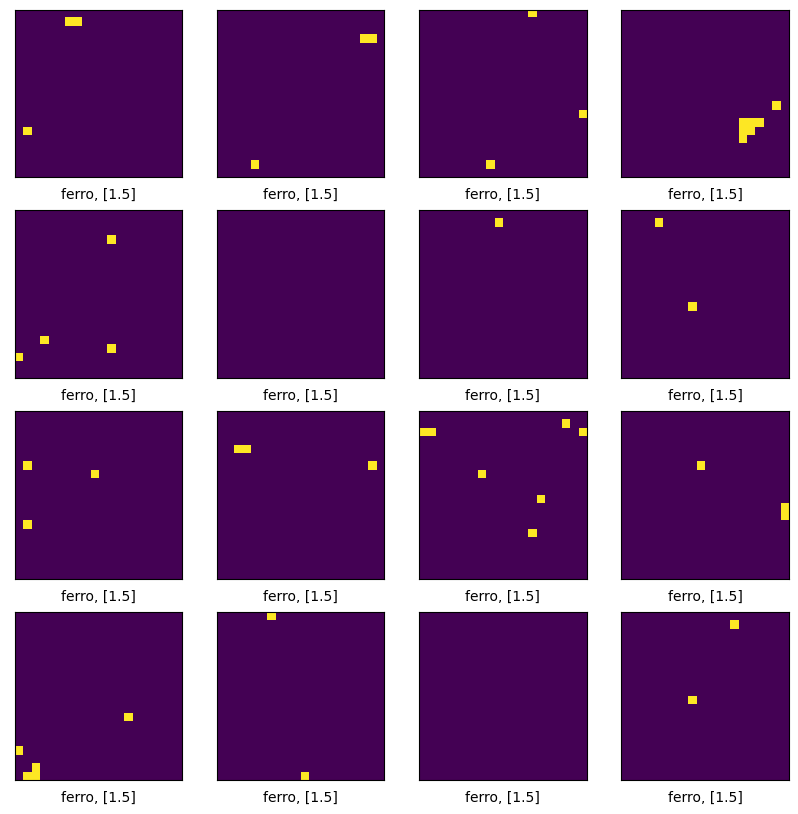

In [5]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_data[i])
    if train_labels[i][0] == 1:
        label = "ferro"
    elif train_label[i][1] == 1:
        label = "para"
    plt.xlabel(f'{label}, {train_temps[i]}')

Define the model

In [6]:
model1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(20, 20)),
    keras.layers.Dense(100, activation=tf.nn.relu6),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

Compile and fit the model

In [7]:
# Compile the model
model1.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model1.fit(x=train_data, y=train_labels, epochs=10, batch_size=128)


Epoch 1/10
129/129 [==============================] - 1s 2ms/step - loss: 0.2377 - accuracy: 0.9044
Epoch 2/10
129/129 [==============================] - 0s 2ms/step - loss: 0.1597 - accuracy: 0.9400
Epoch 3/10
129/129 [==============================] - 0s 2ms/step - loss: 0.1407 - accuracy: 0.9467
Epoch 4/10
129/129 [==============================] - 0s 2ms/step - loss: 0.1323 - accuracy: 0.9519
Epoch 5/10
129/129 [==============================] - 0s 2ms/step - loss: 0.1254 - accuracy: 0.9535
Epoch 6/10
129/129 [==============================] - 0s 2ms/step - loss: 0.1154 - accuracy: 0.9570
Epoch 7/10
129/129 [==============================] - 0s 3ms/step - loss: 0.1057 - accuracy: 0.9594
Epoch 8/10
129/129 [==============================] - 0s 2ms/step - loss: 0.1023 - accuracy: 0.9599
Epoch 9/10
129/129 [==============================] - 0s 2ms/step - loss: 0.0946 - accuracy: 0.9621
Epoch 10/10
129/129 [==============================] - 0s 2ms/step - loss: 0.0886 - accuracy: 0.9663

In [8]:
# Evaluate the model on development data
val_loss, val_acc = model1.evaluate(dev_data, dev_labels)
print('Validation accuracy:', val_acc)
print('Validation loss:', val_loss)

60/60 [==============================] - 0s 1ms/step - loss: 0.1072 - accuracy: 0.9584
Validation accuracy: 0.9584210515022278
Validation loss: 0.10716823488473892


In [9]:
# Generate predictions on development data
predictions = model1.predict(dev_data)
low_predictions = predictions[:, 0]
high_predictions = predictions[:, 1]
df_predictions = pd.DataFrame({'low_prediction': low_predictions, 'high_prediction': high_predictions, 'temp': dev_temps.reshape(-1)})


60/60 [==============================] - 0s 1ms/step


In [10]:
# Calculate means and standard deviations of predictions at different temperatures
df_means = df_predictions.groupby('temp').mean()
df_stds = df_predictions.groupby('temp').std()

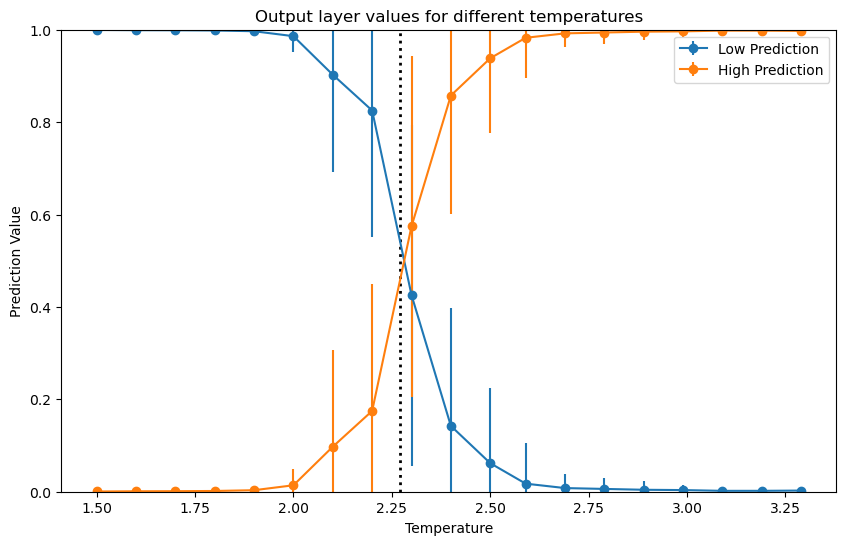

In [11]:
# Plot mean predictions with error bars against temperature
plt.figure(figsize=(10, 6))
plt.errorbar(df_means.index, df_means['low_prediction'], yerr=df_stds['low_prediction'], marker='o', label='Low Prediction')
plt.errorbar(df_means.index, df_means['high_prediction'], yerr=df_stds['high_prediction'], marker='o', label='High Prediction')
plt.ylim([0, 1])
plt.axvline(2.27, c='black', linestyle=':', lw=2)
plt.title("Output layer values for different temperatures")
plt.xlabel("Temperature")
plt.ylabel("Prediction Value")
plt.legend()

In [12]:
# Find incorrectly classified examples based on a condition
bad_predictions = [i for i, (lp, t) in enumerate(zip(low_predictions, dev_temps)) if lp > 0.5 and t >= 2.4]


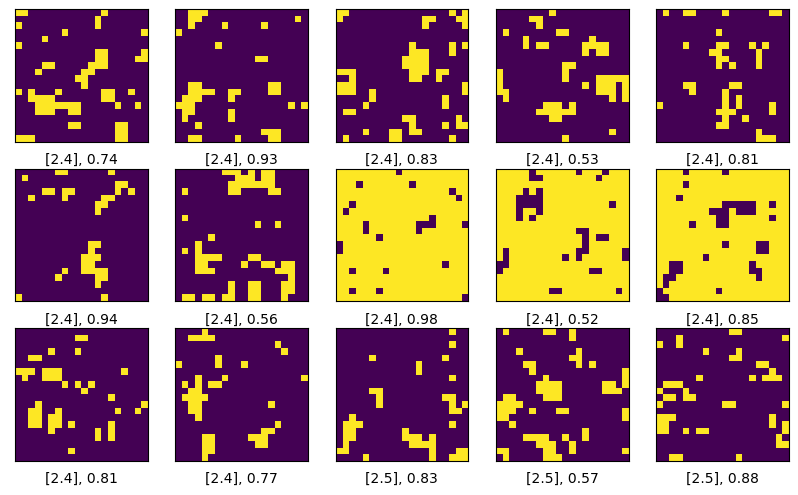

In [13]:
# Plot subset of incorrectly classified examples
plt.figure(figsize=(10, 10))
for i, idx in enumerate(bad_predictions[:15]):
    plt.subplot(5, 5, i + 1)
    plt.imshow(dev_data[idx])
    plt.xlabel(f'{dev_temps[idx]}, {low_predictions[idx]:.2f}')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

plt.show()


In [14]:
# Define periodic padding function
def periodic_padding(image, padding=1):
    upper_pad = image[-padding:, :]
    lower_pad = image[:padding, :]
    partial_image = np.concatenate([upper_pad, image, lower_pad], axis=0)
    left_pad = partial_image[:, -padding:]
    right_pad = partial_image[:, :padding]
    padded_image = np.concatenate([left_pad, partial_image, right_pad], axis=1)
    return padded_image

Text(0.5, 1.0, '20x20 Configuration with Periodic Padding')

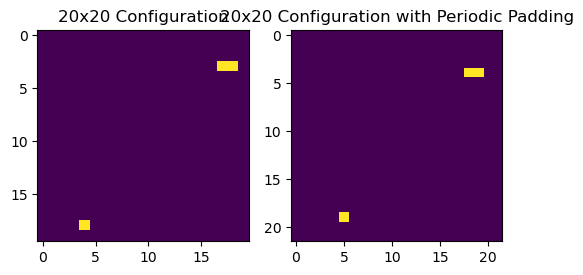

In [15]:
# Visualize the effect of periodic padding
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(train_data[1])
plt.title("20x20 Configuration")
plt.subplot(1, 2, 2)
plt.imshow(periodic_padding(train_data[1]))
plt.title("20x20 Configuration with Periodic Padding")

In [16]:
# Prepare data for the CNN
train_data_CNN = np.array([periodic_padding(x) for x in train_data]).reshape(-1, 22, 22, 1)
dev_data_CNN = np.array([periodic_padding(x) for x in dev_data]).reshape(-1, 22, 22, 1)


In [17]:
# Define the CNN model
model2 = keras.Sequential([
    keras.layers.Conv2D(64, (2, 2), input_shape=(22, 22, 1), padding='valid'),
    keras.layers.ReLU(),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

model2.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])



In [18]:
# Train the model
model2.fit(x=train_data_CNN, y=train_labels, epochs=3, batch_size=128)


Epoch 1/3
129/129 [==============================] - 5s 33ms/step - loss: 0.1355 - accuracy: 0.9441
Epoch 2/3
129/129 [==============================] - 4s 33ms/step - loss: 0.1011 - accuracy: 0.9594
Epoch 3/3
129/129 [==============================] - 4s 33ms/step - loss: 0.0874 - accuracy: 0.9647


In [19]:
# Evaluate the model on development data
val_loss, val_acc = model2.evaluate(dev_data_CNN, dev_labels)
print('Test accuracy:', val_acc)
print('Validation loss:', val_loss)

60/60 [==============================] - 0s 3ms/step - loss: 0.1183 - accuracy: 0.9558
Test accuracy: 0.9557894468307495
Validation loss: 0.11834163963794708


In [20]:
# Generate predictions
predictions2 = model2.predict(dev_data_CNN)
low_predict2 = predictions2[:, 0]
high_predict2 = predictions2[:, 1]

60/60 [==============================] - 0s 3ms/step


In [21]:
# Create a DataFrame for predictions
df4 = pd.DataFrame({'low_prediction': low_predict2, 'high_prediction': high_predict2, 'Temp': dev_temps.reshape(-1,)})

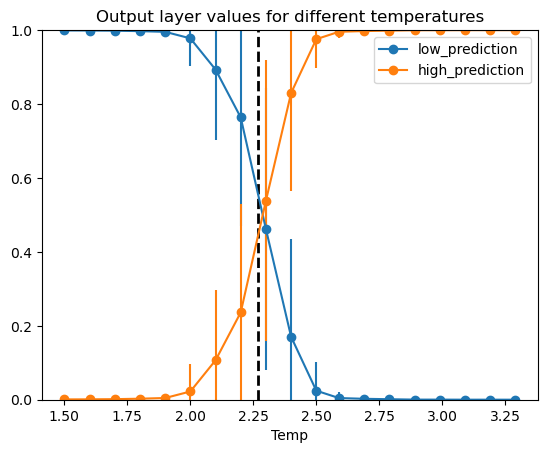

In [22]:
# Plot mean predictions with error bars against temperature
df5 = df4.groupby('Temp').mean()
df6 = df4.groupby('Temp').std()
df5.plot(marker='o', yerr=df6, title="Output layer values for different temperatures")
plt.ylim([0, 1])
plt.axvline(2.27, c='black', linestyle='--', lw=2)

plt.show()